# Timer model's revin parameter should be set to True. 

In [1]:
import os
import json
import torch
import warnings
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForCausalLM
from peft import get_peft_model, LoraConfig, TaskType
from peft import PeftModel
import numpy as np
from utils.timefeatures import time_features
from utils.Warehouse import StandardScaler
warnings.filterwarnings("ignore")


In [2]:
data_path='data/battery/modified_cleaned_250206-1-1-19.csv'
df = pd.read_csv(data_path)
lookback_length = 960
prediction_length = 96
seqs = torch.tensor(df["放电容量(Ah)"][:lookback_length]).unsqueeze(0).float()

In [3]:
origin_timer = AutoModelForCausalLM.from_pretrained('thuml/timer-base-84m', trust_remote_code=True, local_files_only=True)
output = origin_timer.generate(seqs, max_new_tokens=prediction_length)

# Total parameters
total_params = sum(p.numel() for p in origin_timer.parameters())

# Trainable parameters
trainable_params = sum(p.numel() for p in origin_timer.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 84,142,080
Trainable parameters: 84,142,080


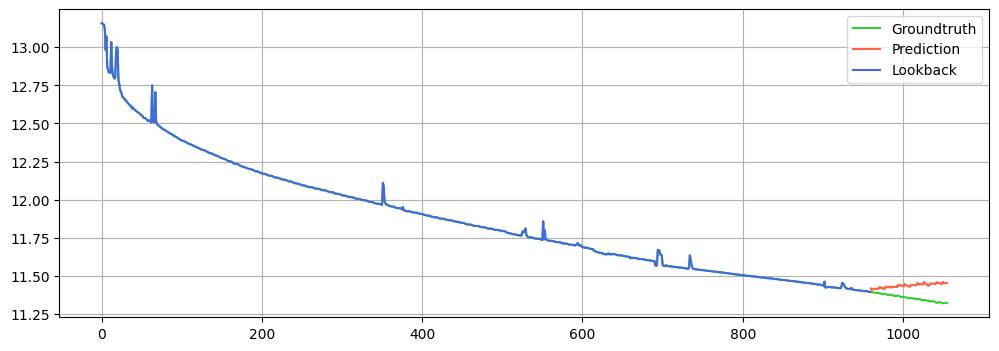

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(df["放电容量(Ah)"][:lookback_length + prediction_length], color="limegreen", label="Groundtruth")
plt.plot(range(lookback_length, lookback_length + prediction_length), output[0], color="tomato", label="Prediction")
plt.plot(df["放电容量(Ah)"][:lookback_length], color="royalblue", label="Lookback")
plt.legend()
plt.grid()
plt.show()

In [5]:
def validate_rl_model(model_path, lora_path, data_path, cache_dir, lookback_length=960, pred_length=96):
    # 加载 RL 微调后的模型（基础 + LoRA 适配器）
    base_model = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True, local_files_only=True, cache_dir=cache_dir)
    model = PeftModel.from_pretrained(base_model, lora_path, cache_dir=cache_dir)
    model.eval().cuda()

    # 加载数据并归一化（和训练一致）
    df = pd.read_csv(data_path)
    seq_raw = df["放电容量(Ah)"].values.astype(np.float32)
    scaler = StandardScaler()
    scaler.fit(seq_raw[:int(0.6 * len(seq_raw))].reshape(-1, 1))  # 与训练时相同比例
    seq_scaled = scaler.transform(seq_raw.reshape(-1, 1)).squeeze()

    # 准备输入（lookback）
    lookback_seq = torch.tensor(seq_scaled[:lookback_length]).unsqueeze(0).cuda()  # [1, lookback_len]

    # 使用 generate() 生成后续序列（注意模型生成的是 token，我们用的是浮点数，这里直接 forward 更合适）
    pred_input = lookback_seq[:, -96:]  # 输入序列长度保持一致
    output = model.generate(pred_input, max_new_tokens=pred_length)
    pred = output[0, -pred_length:].detach().cpu().numpy()

    # 将预测值反归一化
    pred_rescaled = scaler.inverse_transform(pred.reshape(-1, 1)).squeeze()

    # 可视化结果
    plt.figure(figsize=(12, 4))
    full_groundtruth = df["放电容量(Ah)"][:lookback_length + pred_length].values
    plt.plot(full_groundtruth, color="limegreen", label="Groundtruth")
    plt.plot(range(lookback_length, lookback_length + pred_length), pred_rescaled, color="tomato", label="Prediction")
    plt.plot(df["放电容量(Ah)"][:lookback_length], color="royalblue", label="Lookback")
    plt.legend()
    plt.grid()
    plt.title("RL-Lora Battery Prediction")
    plt.xlabel("Time")
    plt.ylabel("放电容量(Ah)")
    plt.tight_layout()
    plt.show()

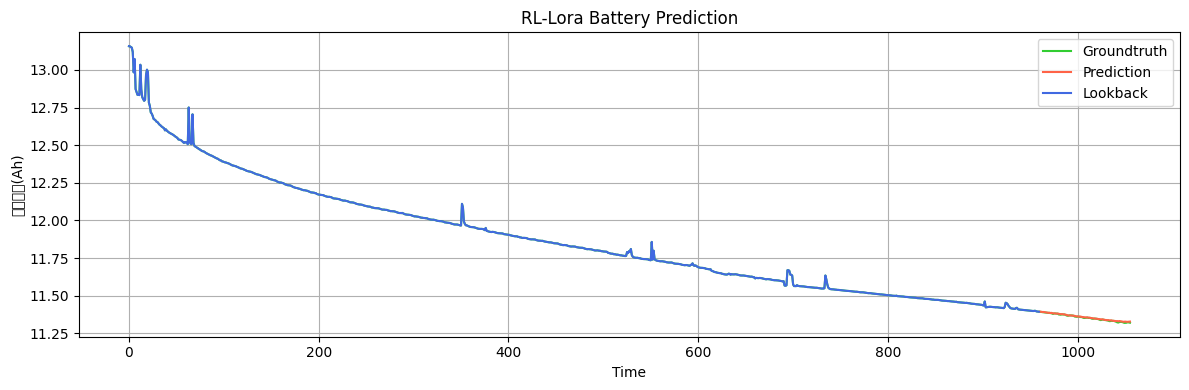

In [6]:
validate_rl_model(
    model_path='thuml/timer-base-84m',
    lora_path="revised_timer/lora_timer_battery",
    data_path=data_path,
    cache_dir='revised_timer',
    lookback_length=960,
    pred_length=96
)